In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print('Changed directory to', os.getcwd())

Changed directory to /morphoml


# Load data

In [3]:
from morphoml.dataprep import load_hdf5

imgs, names = load_hdf5('./data/images/processed_scauto_197.h5')
print('Images shape:', imgs.shape, '; Names shape:', names.shape)
n_gb = np.random.randn(1, imgs.shape[1], imgs.shape[2]).nbytes * imgs.shape[0] / (1024 * 1024 * 1024)
print(f'Needs {n_gb:.1f} GB to load in memory.')

Images shape: (73627, 197, 197) ; Names shape: (73627,)
Needs 21.3 GB to load in memory.


In [4]:
from ipywidgets import interact

def plot_gal(i):
    img, name = imgs[i], names[i]
    print('min', img.min(), 'max', img.max())
    plt.imshow(img)
    plt.suptitle(name)
    
interact(plot_gal, i=(0, 100))

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_gal(i)>

(10000, 197, 197, 3) (5000, 197, 197, 3)
-123.68 151.061


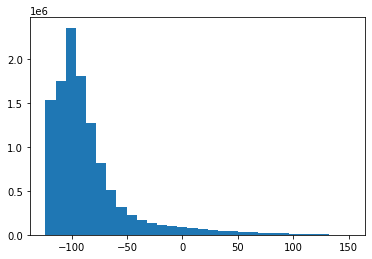

In [5]:
def preprocess_input(x, copy=False):
    """
    Brings input images from [-1, 1] range and (ngal, npix, npix) shape
    into the right format for (most) keras.applications.
    
    The new shape is (ngal, npix, npix, 3), where the greyscale images
    are duplicated across the rgb channels.
    
    The output scaling starts from the [0, 255] range, but subtracts
    a fixed mean for each channel. This matches the "caffe" input
    preprocessing, which is the defualt for keras.applications.
    """
    
    if copy:
        x = x.copy()
    x = 127.5 * (x + 1.) # from [-1, 1] to [0, 255]
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x

ntrain, ntest = 10000, 5000
x_train, x_test = imgs[:ntrain].copy(), imgs[ntrain:(ntrain+ntest)].copy()
x_train, x_test = preprocess_input(x_train), preprocess_input(x_test)
idx_train, idx_test = names[:ntrain].copy(), names[ntrain:(ntrain+ntest)].copy()
print(x_train.shape, x_test.shape)
print(x_train.min(), x_train.max())
plt.hist(x_test[:100, ...].flatten(), bins=30);

In [6]:
df_meta = pd.read_csv('./data/metadata/metadata_valid_morphid.tsv',
                      sep='\t', index_col=0)
print(df_meta.shape)
df_meta.head()

(73627, 30)


,RA,DEC,D25,redshift,GalSize_kpc,D_Mpc,d_pix_kpc,reduced_chi_square,logM_bayes,logM_bayes_err,...,ML_zibetti,RA_leda,DEC_leda,D25_leda,R25_leda,pa_leda,id_gz1,dist_gz1,id_gz2,dist_gz2
SDSS_ID,,,,,,,,,,,,,,,,,,,,,
1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,3.980811,10.328326,0.057643,...,2.553861,231.318646,41.346012,0.516416,4.677351,52.77,552094,0.000016,131054,0.191547
1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.537818,9.834362,0.037180,...,1.054716,236.009916,39.288303,0.441570,2.897344,131.08,572069,0.000104,177157,0.094953
1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.280960,9.851568,0.057156,...,0.805557,237.494992,9.278609,0.629506,1.312200,155.89,577778,0.000041,37238,0.000052
1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.192938,10.439780,0.044860,...,1.775870,242.008785,36.053987,0.557186,1.315225,63.55,596382,0.000021,76320,0.000036
1237662474235085097,251.31645,25.60003,0.512861,0.0681,43.540800,291.857134,0.565985,1.540025,9.999021,0.040437,...,1.205651,251.316496,25.600029,0.510505,3.539973,42.81,624773,0.000070,62784,0.079806


In [7]:
y_train, y_test = np.log10(df_meta.loc[idx_train, 'ML_bayes']), np.log10(df_meta.loc[idx_test, 'ML_bayes'])
print(y_train.shape, y_test.shape)
y_train.head()

(10000,) (5000,)


SDSS_ID
1237648722296897660    0.409041
1237667293729849467    0.312304
1237667430092570789    0.138839
1237668299283824738    0.571249
1237664818211192894    0.209686
Name: ML_bayes, dtype: float64

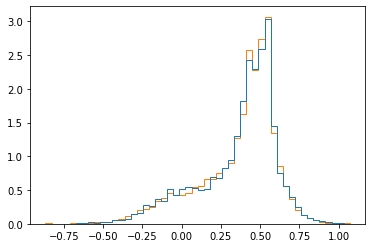

In [8]:
plt.hist([y_test.values.flatten(), y_train.values.flatten()], 50, 
         histtype='step', density=True);

# Construct model

CNN pretrained on imagenet, then some dense layers on top.

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

input_shape = list(x_train.shape)[1:]
cnn = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape,
                                       pooling='max')
topinput = tf.keras.Input(cnn.output.shape[1], name='top_input')
xout = layers.Dense(1024, activation='relu', name='final_dense_1')(topinput)
xout = layers.Dense(512, activation='relu', name='final_dense_2')(xout)
xout = layers.Dense(1, activation='linear', name='final_dense_3')(xout)
topstack = tf.keras.models.Model(inputs=topinput, outputs=xout, name='top_stack')
model = tf.keras.models.Model(inputs=cnn.inputs, outputs=topstack(cnn.output))
model

In [39]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 197, 197, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 101, 101, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [40]:
topstack.summary()

Model: "top_stack"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
top_input (InputLayer)       [(None, 2048)]            0         
_________________________________________________________________
final_dense_1 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
final_dense_2 (Dense)        (None, 512)               524800    
_________________________________________________________________
final_dense_3 (Dense)        (None, 1)                 513       
Total params: 2,623,489
Trainable params: 2,623,489
Non-trainable params: 0
_________________________________________________________________


In [43]:
pred = model.predict(x_train[:100])
print(pred.shape)
pred[:5]

(100, 1)


array([[-112.31543],
       [-293.77045],
       [-144.19702],
       [ 263.0784 ],
       [  89.26279]], dtype=float32)

Note: don't simply put all CNN layers to non-trainable. This will mess with BatchNormalization. See [this](https://stackoverflow.com/questions/51123198/strange-behaviour-of-the-loss-function-in-keras-model-with-pretrained-convoluti/51124511#51124511) stack overflow thread and [this](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/) blog post.

In [13]:
# Only final dense layers are trainable
# for layer in model.layers:
#     layer.trainable = 'final_dense' in layer.name

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [44]:
f_train = cnn.predict(x_train)
f_test = cnn.predict(x_test)

In [45]:
print(f_train.shape)
f_train[:5, ]

(10000, 2048)


array([[1808.0793 ,  404.76257,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [1832.3032 ,  424.4395 ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [1424.6746 ,  218.59335,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [1607.8916 ,  402.90317,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [1453.3961 ,  479.4017 ,    0.     , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

# Training

In [47]:
topstack.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [49]:
topstack.fit(f_train, y_train.values, epochs=20)

Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 11134.9082 - mse: 11152.5527
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 149.3564 - mse: 149.3825
Epoch 3/20
313/313 [==============================] - 1s 3ms/step - loss: 176.9137 - mse: 176.7793
Epoch 4/20
313/313 [==============================] - 1s 3ms/step - loss: 308.5664 - mse: 308.7010
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 5299.0605 - mse: 5307.1650
Epoch 6/20
313/313 [==============================] - 1s 3ms/step - loss: 77.7932 - mse: 77.8740
Epoch 7/20
313/313 [==============================] - 1s 3ms/step - loss: 62.2093 - mse: 62.2118
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 69.8358 - mse: 69.7521
Epoch 9/20
313/313 [==============================] - 1s 3ms/step - loss: 191.8615 - mse: 192.0416
Epoch 10/20
313/313 [==============================] - 1s 3ms/step - loss: 367.6436 - mse: 368.1837
Epoch 11/

In [50]:
y_pred = model.predict(x_test).squeeze()
print(y_pred.shape)

(5000,)


In [55]:
y_pred_train = model.predict(x_train).squeeze()

In [116]:
np.mean(np.square(y_pred_train - y_train))

65.08158193190407

In [24]:
model.evaluate(x_train, y_train.values)

313/313 [==============================] - 14s 45ms/step - loss: 1060.9203 - mse: 1061.0219


[1060.9202880859375, 1061.0218505859375]

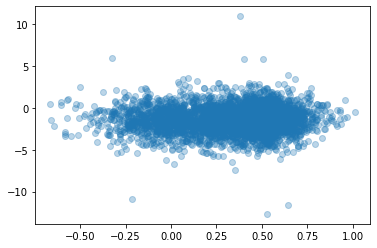

In [51]:
plt.scatter(y_test, y_pred, alpha=0.3)

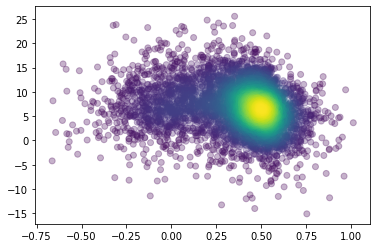

In [59]:
from plotting.preparation import estimate_density

xc, yc, c = estimate_density(y_test, y_pred)
plt.scatter(xc, yc, c=c, alpha=0.3)

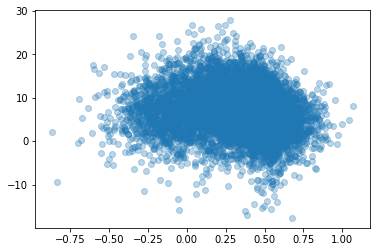

In [ ]:
plt.scatter(y_train, y_pred_train, alpha=0.3)

In [66]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

5000/5000 - 326s - loss: 1599.5051 - mse: 1599.5052

Test accuracy: 1599.5052


# Transform to R50 features

In [75]:
f_train = cnn.predict(x_train)
f_test = cnn.predict(x_test)

In [80]:
feat_names = [f'feat_{i}' for i in range(1, f_train.shape[1]+1)]
df_train = pd.DataFrame(f_train, index=idx_train, columns=feat_names)
print(df_train.shape)
df_train.head()

(10000, 2048)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,...,feat_2000,feat_2001,feat_2002,feat_2003,feat_2004,feat_2005,feat_2006,feat_2007,feat_2008,feat_2009,feat_2010,feat_2011,feat_2012,feat_2013,feat_2014,feat_2015,feat_2016,feat_2017,feat_2018,feat_2019,feat_2020,feat_2021,feat_2022,feat_2023,feat_2024,feat_2025,feat_2026,feat_2027,feat_2028,feat_2029,feat_2030,feat_2031,feat_2032,feat_2033,feat_2034,feat_2035,feat_2036,feat_2037,feat_2038,feat_2039,feat_2040,feat_2041,feat_2042,feat_2043,feat_2044,feat_2045,feat_2046,feat_2047,feat_2048
1237648722296897660,1808.082397,404.763489,0.0,3197.615723,0.0,0.0,817.414612,0.0,971.618286,0.0,0.0,0.0,3900.722900,0.0,0.0,2823.882812,747.261047,0.0,0.0,0.0,0.0,154.436951,844.353210,3303.184570,0.0,0.0,2312.498291,0.0,986.766296,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,346.647919,0.0,0.0,593.326477,404.922150,553.851379,0.0,471.227631,0.0,0.0,0.0,1424.669922,0.0,...,3049.990479,0.0,103.222847,968.050110,143.014450,0.0,1512.531616,779.182007,0.000000,0.0,1333.323242,97.139107,0.0,0.0,1716.776001,1453.287231,0.0,3912.842529,395.454224,0.0,0.0,975.531189,0.0,0.0,914.018127,0.0,0.0,0.0,268.158630,0.0,343.120880,0.0,0.0,0.0,1326.863159,0.0,0.0,0.0,0.0,3546.881836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237667293729849467,1832.302612,424.433014,0.0,3016.961670,0.0,0.0,845.649658,0.0,982.285156,0.0,0.0,0.0,3770.239746,0.0,0.0,2927.143066,706.652771,0.0,0.0,0.0,0.0,174.925552,433.021118,3267.721924,0.0,0.0,2374.157227,0.0,996.528259,0.0,0.0,92.874489,0.0,0.0,0.0,0.0,277.505615,0.0,0.0,809.339050,453.854065,729.668701,0.0,664.962891,0.0,0.0,0.0,1435.907959,0.0,...,2861.573242,0.0,100.201828,970.308716,376.529663,0.0,1537.475952,816.205017,140.234299,0.0,756.794067,91.036766,0.0,0.0,1822.771118,1353.676392,0.0,3735.593994,279.146179,0.0,0.0,1060.993286,0.0,0.0,812.217346,0.0,0.0,0.0,246.766769,0.0,264.187805,0.0,0.0,0.0,1408.003662,0.0,0.0,0.0,0.0,3260.258545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237667430092570789,1424.670410,218.589767,0.0,3278.800781,0.0,0.0,915.482056,0.0,718.834473,0.0,0.0,0.0,5022.213379,0.0,0.0,3211.686035,740.686584,0.0,0.0,0.0,0.0,296.742065,372.258362,2945.384277,0.0,0.0,2192.884277,0.0,1113.674194,0.0,0.0,523.145569,0.0,0.0,0.0,0.0,305.452972,0.0,0.0,370.507965,399.933075,474.318726,0.0,590.784912,0.0,0.0,0.0,1387.537964,0.0,...,2656.353516,0.0,29.003452,1289.602783,0.000000,0.0,1331.473145,536.549377,0.000000,0.0,737.570862,84.024284,0.0,0.0,1690.820312,1505.873413,0.0,3663.847168,200.453568,0.0,0.0,1098.237793,0.0,0.0,996.807861,0.0,0.0,0.0,239.163300,0.0,109.504478,0.0,0.0,0.0,1298.409302,0.0,0.0,0.0,0.0,3785.806152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237668299283824738,1607.891724,402.901764,0.0,2809.368408,0.0,0.0,970.401550,0.0,878.013489,0.0,0.0,0.0,3716.000977,0.0,0.0,2394.793701,824.816040,0.0,0.0,0.0,0.0,0.000000,565.899536,3476.294922,0.0,0.0,2256.864014,0.0,941.640808,0.0,0.0,463.042236,0.0,0.0,0.0,0.0,287.430359,0.0,0.0,125.880371,404.520782,805.557678,0.0,314.157532,0.0,0.0,0.0,1370.159668,0.0,...,2662.453369,0.0,0.000000,702.929810,0.000000,0.0,1389.204590,670.481201,0.000000,0.0,0.000000,67.294762,0.0,0.0,1779.586914,1533.985352,0.0,3664.222168,322.161743,0.0,0.0,1170.693848,0.0,0.0,972.902893,0.0,0.0,0.0,248.279343,0.0,272.119110,0.0,0.0,0.0,1258.153809,0.0,0.0,0.0,0.0,3432.537109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237664818211192894,1453.397095,479.399597,0.0,3036.860840,0.0,0.0,936.330139,0.0,1075.746704,0.0,0.0,0.0,4366.477051,0.0,0.0,2399.945068,789.370300,0.0,0.0,0.0,0.0,218.354874,570.521057,3447.749268,0.0,0.0,2283.293701,0.0,1049.623779,0.0,0.0,360.336548,0.0,0.0,0.0,0.0,327.102722,0.0,0.0,262.614319,392.248474,506.305878,0.0,38

In [81]:
df_train.describe()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,...,feat_2000,feat_2001,feat_2002,feat_2003,feat_2004,feat_2005,feat_2006,feat_2007,feat_2008,feat_2009,feat_2010,feat_2011,feat_2012,feat_2013,feat_2014,feat_2015,feat_2016,feat_2017,feat_2018,feat_2019,feat_2020,feat_2021,feat_2022,feat_2023,feat_2024,feat_2025,feat_2026,feat_2027,feat_2028,feat_2029,feat_2030,feat_2031,feat_2032,feat_2033,feat_2034,feat_2035,feat_2036,feat_2037,feat_2038,feat_2039,feat_2040,feat_2041,feat_2042,feat_2043,feat_2044,feat_2045,feat_2046,feat_2047,feat_2048
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.000000,10000.000000,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.000000,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.0,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.0,10000.000000,10000.0,10000.000000,10000.0,10000.0,10000.0
mean,1477.695557,325.961456,0.585416,3102.697754,0.100416,0.0,902.070801,0.0,897.720398,0.0,0.0,0.000169,4501.130859,0.0,0.0,2622.645264,801.767761,0.052497,0.0,0.008373,0.0,167.600220,423.110199,3358.978027,1.426936,0.0,2270.365967,0.0,982.091309,0.0,0.0,361.933105,0.0,0.0,0.008969,0.689918,306.026154,0.066559,0.013436,180.177048,403.560089,719.750061,0.0,442.878601,0.0,14.379942,0.0,1388.834961,0.022641,...,2794.493896,0.529532,61.939949,1113.446045,28.926363,3.655592,1451.004028,592.807617,3.295135,0.018295,443.378601,77.107193,0.029109,0.0,1690.562012,1491.795166,0.509446,3723.801270,243.333832,0.280195,0.011152,1061.726929,0.0,0.341436,999.808472,0.0,0.0,0.0,255.048798,0.0,71.079704,0.312214,3.309684,0.0,1311.727051,0.0,0.0,1.429202,0.0,3605.204346,0.0,0.0,0.0,2.110391,0.0,0.453452,0.0,0.0,0.0
std,172.884460,123.863266,11.201339,186.363739,5.773842,0.0,106.009529,0.0,130.382721,0.0,0.0,0.016907,726.188232,0.0,0.0,290.079285,52.456455,3.702438,0.0,0.837314,0.0,86.528564,327.269836,174.033340,21.949760,0.0,129.266907,0.0,92.187820,0.0,0.0,142.681061,0.0,0.0,0.896863,9.370283,34.659309,4.809577,1.343555,233.123459,14.851987,205.948807,0.0,212.777557,0.0,57.017960,0.0,116.516251,0.644509,...,157.137436,8.951339,49.873848,275.433502,77.695366,27.920740,116.814827,185.681503,22.429697,1.829450,440.066193,11.911162,0.937848,0.0,105.335304,169.214691,15.550723,181.215866,151.721771,8.178987,1.036689,119.855408,0.0,3.212994,113.192894,0.0,0.0,0.0,11.451327,0.0,132.600098,9.693914,35.183987,0.0,123.416031,0.0,0.0,18.565702,0.0,181.961227,0.0,0.0,0.0,33.003090,0.0,11.930309,0.0,0.0,0.0
min,950.459290,0.000000,0.000000,2176.577637,0.000000,0.0,428.150665,0.0,415.547760,0.0,0.0,0.000000,380.571075,0.0,0.0,1131.864014,509.181091,0.000000,0.0,0.000000,0.0,0.000000,0.000000,2109.892578,0.000000,0.0,1465.000000,0.0,637.645630,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,63.770817,0.000000,0.000000,0.000000,272.728729,89.661423,0.0,0.000000,0.0,0.000000,0.0,947.219299,0.000000,...,2012.54

In [83]:
df_test = pd.DataFrame(f_test, index=idx_test, columns=feat_names)
print(df_test.shape)
dropcols = [col for col in feat_names if (np.all(df_train[col] == 0) and (np.all(df_test[col] == 0)))]
print(len(dropcols))
dropcols[:5]

(5000, 2048)
718


['feat_6', 'feat_8', 'feat_10', 'feat_11', 'feat_14']

In [84]:
df_train = df_train.drop(columns=dropcols)
df_test = df_test.drop(columns=dropcols)
df_train.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_7,feat_9,feat_12,feat_13,feat_16,feat_17,feat_18,feat_20,feat_22,feat_23,feat_24,feat_25,feat_27,feat_29,feat_32,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_44,feat_46,feat_48,feat_49,feat_50,feat_52,feat_53,feat_54,feat_55,feat_57,feat_60,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_71,feat_72,feat_73,feat_75,...,feat_1979,feat_1980,feat_1982,feat_1984,feat_1985,feat_1986,feat_1987,feat_1989,feat_1990,feat_1991,feat_1992,feat_1993,feat_1994,feat_1995,feat_1997,feat_1999,feat_2000,feat_2001,feat_2002,feat_2003,feat_2004,feat_2005,feat_2006,feat_2007,feat_2008,feat_2009,feat_2010,feat_2011,feat_2012,feat_2014,feat_2015,feat_2016,feat_2017,feat_2018,feat_2019,feat_2020,feat_2021,feat_2023,feat_2024,feat_2028,feat_2030,feat_2031,feat_2032,feat_2034,feat_2037,feat_2039,feat_2042,feat_2043,feat_2045
1237648722296897660,1808.082397,404.763489,0.0,3197.615723,0.0,817.414612,971.618286,0.0,3900.722900,2823.882812,747.261047,0.0,0.0,154.436951,844.353210,3303.184570,0.0,2312.498291,986.766296,0.000000,0.0,0.0,346.647919,0.0,0.0,593.326477,404.922150,553.851379,471.227631,0.0,1424.669922,0.0,0.0,1822.450928,68.261711,0.0,0.0,0.0,0.0,510.121063,0.0,0.0,369.338013,37.149426,0.0,0.0,63.056122,0.0,116.528786,...,0.000000,0.0,0.0,2541.908936,0.0,3828.438965,0.000,0.0,0.0,0.0,255.895218,807.700684,0.0,65.648636,90.324059,0.0,3049.990479,0.0,103.222847,968.050110,143.014450,0.0,1512.531616,779.182007,0.000000,0.0,1333.323242,97.139107,0.0,1716.776001,1453.287231,0.0,3912.842529,395.454224,0.0,0.0,975.531189,0.0,914.018127,268.158630,343.120880,0.0,0.0,1326.863159,0.0,3546.881836,0.0,0.0,0.0
1237667293729849467,1832.302612,424.433014,0.0,3016.961670,0.0,845.649658,982.285156,0.0,3770.239746,2927.143066,706.652771,0.0,0.0,174.925552,433.021118,3267.721924,0.0,2374.157227,996.528259,92.874489,0.0,0.0,277.505615,0.0,0.0,809.339050,453.854065,729.668701,664.962891,0.0,1435.907959,0.0,0.0,1710.704590,80.972237,0.0,0.0,0.0,0.0,895.501648,0.0,0.0,572.647949,34.024212,0.0,0.0,57.275707,0.0,358.687744,...,0.000000,0.0,0.0,2460.172607,0.0,4227.690918,0.000,0.0,0.0,0.0,577.215332,797.792480,0.0,70.573517,380.044067,0.0,2861.573242,0.0,100.201828,970.308716,376.529663,0.0,1537.475952,816.205017,140.234299,0.0,756.794067,91.036766,0.0,1822.771118,1353.676392,0.0,3735.593994,279.146179,0.0,0.0,1060.993286,0.0,812.217346,246.766769,264.187805,0.0,0.0,1408.003662,0.0,3260.258545,0.0,0.0,0.0
1237667430092570789,1424.670410,218.589767,0.0,3278.800781,0.0,915.482056,718.834473,0.0,5022.213379,3211.686035,740.686584,0.0,0.0,296.742065,372.258362,2945.384277,0.0,2192.884277,1113.674194,523.145569,0.0,0.0,305.452972,0.0,0.0,370.507965,399.933075,474.318726,590.784912,0.0,1387.537964,0.0,0.0,1471.004028,77.069801,0.0,0.0,0.0,0.0,621.490845,0.0,0.0,924.154968,32.399921,0.0,0.0,46.917355,0.0,0.000000,...,0.000000,0.0,0.0,2425.739502,0.0,3925.550781,5.083,0.0,0.0,0.0,67.724541,687.205078,0.0,86.564850,185.724075,0.0,2656.353516,0.0,29.003452,1289.602783,0.000000,0.0,1331.473145,536.549377,0.000000,0.0,737.570862,84.024284,0.0,1690.820312,1505.873413,0.0,3663.847168,200.453568,0.0,0.0,1098.237793,0.0,996.807861,239.163300,109.504478,0.0,0.0,1298.409302,0.0,3785.806152,0.0,0.0,0.0
1237668299283824738,1607.891724,402.901764,0.0,2809.368408,0.0,970.401550,878.013489,0.0,3716.000977,2394.793701,824.816040,0.0,0.0,0.000000,565.899536,3476.294922,0.0,2256.864014,941.640808,463.042236,0.0,0.0,287.430359,0.0,0.0,125.880371,404.520782,805.557678,314.157532,0.0,1370.159668,0.0,0.0,1172.567749,56.317184,0.0,0.0,0.0,0.0,438.412689,0.0,0.0,416.707947,32.161465,0.0,0.0,57.673534,0.0,50.446678,...,0.000000,0.0,0.0,2808.618652,0.0,4276.289551,0.000,0.0,0.0,0.0,228.940140,718.657532,0.0,107.740417,326.900513,0.0,2662.453369,0.0,0.000000,702.929810,0.000000,0.0,1389.204590,670.481201,0.000000,0.0,0.000000,67.294762,0.0,1779.586914,1533.985352,0.0,3664.222168,322.161743,0.0,0.0,1170.693848,0.0,972.902893,248.279343,2

In [85]:
df_train.to_csv('./data/cnnfeats/r50v2_imagenet_train.tsv', sep='\t')
df_test.to_csv('./data/cnnfeats/r50v2_imagenet_test.tsv', sep='\t')

# LGBM

In [90]:
df_train.shape

(10000, 1330)

In [91]:
import lightgbm as lgb

train_data = lgb.Dataset(df_train[:8500], label=y_train[:8500])
val_data = lgb.Dataset(df_train[8500:], label=y_train[8500:])
test_data = lgb.Dataset(df_test, label=y_test)

In [104]:
lgbm_params = {'objective': 'regression_l1', 'num_threads': 2, 'metric': ['rmse', 'mae'], 'min_data_in_leaf': 150,
               'learning_rate': 0.01,  'max_depth': -1, 'max_bin': 255,
               'feature_fraction': 0.4, 'bagging_fraction': 0.8, 'bagging_freq': 40,}
num_round = 2000
bst = lgb.train(lgbm_params, train_data,
                 num_boost_round=num_round,
                 valid_sets=val_data,
                 verbose_eval=100,
                 early_stopping_rounds=100
                )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.237854	valid_0's l1: 0.162976
[200]	valid_0's rmse: 0.233546	valid_0's l1: 0.158439
[300]	valid_0's rmse: 0.23175	valid_0's l1: 0.156656
[400]	valid_0's rmse: 0.230732	valid_0's l1: 0.156108
[500]	valid_0's rmse: 0.230056	valid_0's l1: 0.1555
[600]	valid_0's rmse: 0.229539	valid_0's l1: 0.155197
[700]	valid_0's rmse: 0.229265	valid_0's l1: 0.154962
[800]	valid_0's rmse: 0.228869	valid_0's l1: 0.154797
[900]	valid_0's rmse: 0.22876	valid_0's l1: 0.154652
[1000]	valid_0's rmse: 0.228566	valid_0's l1: 0.154553
[1100]	valid_0's rmse: 0.228271	valid_0's l1: 0.15445
[1200]	valid_0's rmse: 0.228172	valid_0's l1: 0.154442
[1300]	valid_0's rmse: 0.228046	valid_0's l1: 0.154362
[1400]	valid_0's rmse: 0.227982	valid_0's l1: 0.154314
[1500]	valid_0's rmse: 0.227801	valid_0's l1: 0.154293
[1600]	valid_0's rmse: 0.227458	valid_0's l1: 0.154255
[1700]	valid_0's rmse: 0.227297	valid_0's l1: 0.154187
Early stopping, b

In [105]:
y_pred = bst.predict(df_test)
print(y_pred.shape)
y_pred[:5]

(5000,)


array([0.34994677, 0.52526019, 0.27233142, 0.43169695, 0.34853977])

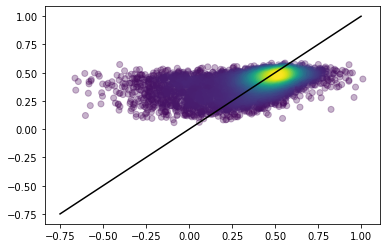

In [106]:
from plotting.preparation import estimate_density

xc, yc, c = estimate_density(y_test, y_pred)
plt.scatter(xc, yc, c=c, alpha=0.3)
xlim = [-0.75, 1.]
plt.plot(xlim, xlim, 'k-')

In [108]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.17138155663936627